In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import pyNBS as nbs
import glob

# Preprocess data

In [3]:
# Some old code...

dirs=["survival","network"]
for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

DIR4NBS = "/cellar/data/users/wzhang1984/forNBS/"

id2gene = {}
for line in open(DIR4NBS+"Homo_sapiens.gene_info").read().rstrip().split("\n")[1:]:
    row = line.split("\t")
    id2gene[row[1]] = row[2]

gene2id={}
for line in open(DIR4NBS+"gene2id.txt").read().rstrip().split("\n"):
    row = line.split("\t")
    gene2id[row[0]] = row[1]


id2hallmark = {}
for line in open(DIR4NBS+"hallmarks.txt").read().rstrip().split("\n"):
    row = line.split("\t")
    if len(row)>1:
        for ID in row[2:]:
            if not ID in id2hallmark:
                id2hallmark[ID] = {}
            id2hallmark[ID][row[0].split("|")[1]] = 1

for line in open(DIR4NBS+"oncogene_tsg.txt").read().rstrip().split("\n"):
    row = line.split("\t")
    if row[0] in gene2id:
        ID = gene2id[row[0]]
        if ID not in id2hallmark:
            id2hallmark[ID] = {}
        id2hallmark[ID][row[1]] = 1

rearrangements_fns=glob.glob(DIR4NBS+"rearrangements_*.txt")
for fn in rearrangements_fns:
    for line in open(fn).read().rstrip().split("\n"):
        row = line.split("\t")
        anno = fn.split("/")[-1].split(".")[0]
        g_list = row[0].split(",")
        g_list.extend(row[1].split(","))
        for g in g_list:
            if g in gene2id:
                ID = gene2id[g]
                if ID not in id2hallmark:
                    id2hallmark[ID] = {}
                id2hallmark[ID][anno] = 1

for line in open(DIR4NBS+"cancerPredispositionGenes.txt").read().rstrip().split("\n"):
    row = line.split("\t")
    if row[0] in gene2id:
        ID = gene2id[row[0]]
        if ID not in id2hallmark:
            id2hallmark[ID] = {}
        id2hallmark[ID]["predisposition"] = 1

whitelist=set()
for line in open('../eQTL_rev/whitelist.txt').read().rstrip().split('\n'):
    gene = line
    whitelist.add(gene)

pat2mut = {}
pat2mut_source = {}
gene2score = {}
gene2og_tsg = {}
for line in open('../eQTL_rev/summarize_muts2info_min.txt').read().rstrip().split('\n')[1:]:
    row = line.split('\t')
    gene = row[0]
    gene2score[gene] = float(row[-1])
    gene2og_tsg[gene] = row[1]

mut2pat = {}
pats = set()
for line in open('../eQTL_rev/summarize_muts4oncoprinter.txt').read().rstrip().split('\n')[1:]:
    row = line.split('\t')
    pat = row[0]
    pats.add(pat)
    if len(row) == 1:
        continue
    if pat not in pat2mut:
        pat2mut[pat] = {}
        pat2mut_source[pat] = set()
    gene = row[1]
#     if gene not in whitelist:
#         continue
    if gene not in gene2score:
        continue
    if gene not in mut2pat:
        mut2pat[gene] = [set(), set(), '']
    if gene2score[gene] > 0:
        mut2pat[gene][2] = 'up'
        if row[2]=='UP':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene] = set()
            pat2mut[pat][gene].add('nc\tup')
            pat2mut_source[pat].add(gene+'|ncmut')
            mut2pat[gene][1].add(pat)
        elif gene2og_tsg[gene] == 'ncmut' and gene != 'TERT':
            continue
        if (gene2og_tsg[gene] == 'Oncogene' and row[3] == 'MISSENSE') or row[2] == 'AMP':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene] = set()
            pat2mut[pat][gene].add('cds\tup')
            pat2mut_source[pat].add(gene+'|cds')
            mut2pat[gene][0].add(pat)
    elif gene2score[gene] < 0:
        mut2pat[gene][2] = 'down'
        if row[2] == 'DOWN':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene] = set()
            pat2mut[pat][gene].add('nc\tdown')
            pat2mut_source[pat].add(gene+'|ncmut')
            mut2pat[gene][1].add(pat)
        elif gene2og_tsg[gene] == 'ncmut':
            continue
        if row[3]=='TRUNC' or row[3]=='MISSENSE' or row[2]=='HOMDEL':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene] = set()
            pat2mut[pat][gene].add('cds\tdown')
            pat2mut_source[pat].add(gene+'|cds')
            mut2pat[gene][0].add(pat)
        
print len(pats)
line_out = 'gene\tmut_c\tmut_nc\tintersect\tunion\tup_down\thallmarks\n'
for g in mut2pat:
    mut_c = mut2pat[g][0]
    mut_nc = mut2pat[g][1]
    hallmarks = ''
    if g in gene2id and gene2id[g] in id2hallmark:
        hallmarks = ', '.join(id2hallmark[gene2id[g]])
    line_out += '{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(g,float(len(mut_c-mut_nc))/len(pats),
                                                      float(len(mut_nc-mut_c))/len(pats),
                                                      float(len(mut_c&mut_nc))/len(pats),
                                                      float(len(mut_c|mut_nc))/len(pats),
                                                      mut2pat[g][2],
                                                      hallmarks)
open('./network/FI_id_mut2n.noa', 'w').write(line_out)

pat2batch={}

for line in open("../pat2clin4surv.txt").read().rstrip().split("\n")[1:]:
    row = line.split("\t")
    pat2batch[row[0]] = [row[0].split("-")[1], row[1].upper()]


line_pat = ""
disease2count = {}
for pat in sorted(pat2mut):
    line_pat += "\t".join([pat, pat2batch[pat][0], pat2batch[pat][1],
                           str(len(pat2mut[pat])), ",".join(pat2mut_source[pat])]) + "\n"
    if not pat2batch[pat][1] in disease2count:
        disease2count[pat2batch[pat][1]] = 0
    disease2count[pat2batch[pat][1]] += 1

open("pat2mut_pat.txt", "w").write(line_pat)

open("disease2count.txt", "w").write("\n".join([i+"\t"+str(disease2count[i]) for i in disease2count]))

line_out = ''
for pat in pat2mut:
    for gene in pat2mut[pat]:
        for anno in pat2mut[pat][gene]:
            line_out += '{}\t{}\t{}\n'.format(pat[:12],gene,anno)
open('pat2mut.txt','wb').write(line_out)

832


# Create Personalized PageRank matrix

In [4]:
file_name = '/cellar/data/users/wzhang1984/forNBS/FIsInGene_031516_with_annotations.txt'
network_output_dir = 'FI_prop'
network, gene2index = nbs.load_network(file_name, network_output_dir)

* Loading PPI...
	- Edges: 228919
	- Nodes: 12175
* Removing self-loops, multi-edges, and restricting to largest connected component...
	- Largest CC Edges: 228827
	- Largest CC Nodes: 12033
* Saving updated node list to file...


In [5]:
# It takes a long time to compute the inverse matrix. But it only has to be done once.

rst_prob = 0.3

PPR = nbs.create_ppr_matrix(network, rst_prob, network_output_dir)

* Creating PPR  matrix...


# Load PPR matrix

In [23]:
network_output_dir = 'FI_prop'

PPR = np.load('{}/ppr_0.3.npy'.format(network_output_dir))

# Network propagation

In [24]:
output_dir = network_output_dir
file_name = 'pat2mut.txt'
mutation_profile, pat2index = nbs.load_mutation(file_name,output_dir,gene2index)

	- Genes in adjacency matrix: 222
* Saving patient list to file...


In [25]:
pat_diff = nbs.run_diffusion_PPR(PPR,mutation_profile)

# write propagated network on hard disk
with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
    np.save(file_handle,pat_diff)

print 'Finish propagating the data...'

Finish propagating the data...


# Clustering

In [26]:
M_prop = np.load('FI_prop/prop_pat_mut.npy')
with open('FI_prop/index_genes') as file_handle:
    genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
with open('FI_prop/index_patients') as file_handle:
    pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
M_prop = pd.DataFrame(data=M_prop, index=pats, columns=genes)

In [27]:
M_prop_pca, pca_components, explained_variance_ratio = nbs.run_pca(M_prop)

In [28]:
explained_variance_ratio.tofile('explained_variance_ratio.txt',sep='\n')

In [29]:
explained_variance_ratio[:70].sum()

0.73682161318738548

In [39]:
labels = nbs.run_clustering_mp(M_prop_pca.iloc[:, :70], 10, nbs.run_SpectralClustering)

In [40]:
labels.K10.value_counts()

7    192
2     89
0     82
5     74
8     72
4     71
1     68
6     59
3     54
9     49
Name: K10, dtype: int64

# Survival analysis

In [41]:
nbs.run_coxph('../pat2clin4surv.txt', labels, 'survival/')

0

# Subnetworks

In [42]:
M = pd.DataFrame(data=mutation_profile,index=pats,columns=genes)
K = labels.loc[:,'K10']
test_n_processes = 24
pat2mut_fn = 'pat2mut.txt'
network_fn = '/cellar/data/users/wzhang1984/forNBS/FIsInGene_031516_with_annotations.txt'
output_dir = 'network'
ttest_fdr_cut = 0.3

# nbs.subnetwork_wrapper(M.loc[:,sorted(M.columns & whitelist)], M_prop.loc[:,sorted(M_prop.columns & whitelist)], K, 
#                        test_n_processes, pat2mut_fn, network_fn, output_dir, ttest_fdr_cut)
nbs.subnetwork_wrapper(M, M_prop, K, 
                       test_n_processes, pat2mut_fn, network_fn, output_dir, ttest_fdr_cut)

Finish ttest
Finish Fisher exact test
Summarizing subtype signatures
Summarizing subnetworks


0

# postProcess

In [43]:
# Compare subtypes and tissues

pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)
subtype2disease=pat2surv.set_index(['K10','DISEASE'])
subtype2disease['counter']=1
subtype2disease.counter.groupby(level=[1, 0]).sum().unstack().to_csv('subtype2disease.txt',sep='\t')

In [44]:
# Trace the hierarchy of clustering

nPats_cut=10

pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)
K2pat={}
for index,row in pat2surv.iterrows():
    pat=index
    for k in range(2,11):
        column='K{}'.format(k)
        if k not in K2pat:
            K2pat[k]={}
        subtype=str(row[column])
        if subtype not in K2pat[k]:
            K2pat[k][subtype]=set()
        K2pat[k][subtype].add(pat)        

line_out=''
line_sif='subtype1\tsubtype2\tnPats\n'
for k in sorted(K2pat.keys()[:-1]):
    print k
    line_out+='\n'+str(k)+'\n'
    for subtype_2 in sorted(K2pat[k+1].keys()):
        line_out+='\t'+subtype_2
    line_out+='\n'
    for subtype in sorted(K2pat[k].keys()):
        line_out+=subtype
        for subtype_2 in sorted(K2pat[k+1].keys()):
            nPats=len(K2pat[k][subtype] & K2pat[k+1][subtype_2])
            line_out+='\t{}'.format(nPats)
            if nPats<nPats_cut:
                continue
            line_sif+='{}-{}\t{}-{}\t{}\n'.format(k,subtype,k+1,subtype_2,nPats)
        line_out+='\n'

open('hierarchy.txt','wb').write(line_out)
open('hierarchy_network.txt','wb').write(line_sif)

line_noa='subtype\tnPats\n'
for k in sorted(K2pat.keys()):
    for subtype in sorted(K2pat[k].keys()):
        line_noa+='{}-{}\t{}\n'.format(k,subtype,len(K2pat[k][subtype]))
open('hierarchy_network.noa','wb').write(line_noa)

2
3
4
5
6
7
8
9


In [8]:
# Create files for oncoprinter plot
# Old code...

'''
To override the input of the OncoPrinter from cBioPortal
non-coding mutation -> UP/DOWN EXP
'''

import os

K=10
cluster2g={}
for cluster in range(K):
    cluster2g[cluster]=set()
    for line in open("network/subtype_{}.noa".format(cluster)).read().splitlines()[1:]:
        a=line.split("\t")
        if float(a[3])<=0.1 and float(a[4])<=0.05:
            cluster2g[cluster].add(a[0])

pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)

gene2score={}
gene2og_tsg={}
for line in open('../eQTL_rev/summarize_muts2info_min.txt').read().splitlines()[1:]:
    a=line.split('\t')
    gene2score[a[0]]=float(a[-1])
    gene2og_tsg[a[0]]=a[1]

header='Sample\tgene\tAlteration\tType\n'
cluster2line_out={}
for line in open('../eQTL_rev/summarize_muts4oncoprinter.txt').read().splitlines()[1:]:
    a=line.split('\t')
    if len(a)==1:
        continue
    pat=a[0][:12]
    if pat not in pat2surv.index:
        continue
    cluster=pat2surv.loc[pat,'K10']
    if cluster not in cluster2line_out:
        cluster2line_out[cluster]=header
    g=a[1]
    if g not in cluster2g[cluster]:
        continue
    Alteration=a[2]
    Type=a[3]
    if gene2score[g]>0:
        if (gene2og_tsg[g]=='Oncogene' and a[3]=='MISSENSE') or a[2]=='AMP' or a[2]=='UP':
            if Alteration=='AMP':
                if gene2og_tsg[g]=='ncmut' and g!='TERT':
                    continue
                Alteration='UP'
                Type='EXP'
            elif Alteration=='UP':
                Alteration='AMP'
                Type='CNA'
            cluster2line_out[cluster]+='{}\t{}\t{}\t{}\n'.format(pat,a[1],Alteration,Type)
    elif gene2score[g]<0:
        if a[3]=='TRUNC' or a[3]=='MISSENSE' or a[2]=='HOMDEL' or a[2]=='DOWN':
            if Alteration=='HOMDEL':
                if gene2og_tsg[g]=='ncmut':
                    continue
                Alteration='DOWN'
                Type='EXP'
            elif Alteration=='DOWN':
                Alteration='HOMDEL'
                Type='CNA'
            cluster2line_out[cluster]+='{}\t{}\t{}\t{}\n'.format(pat,a[1],Alteration,Type)

os.system('mkdir -p forOncoPrinter')

for cluster in cluster2line_out:
    open('./forOncoPrinter/{}.txt'.format(cluster),'wb').write(cluster2line_out[cluster])

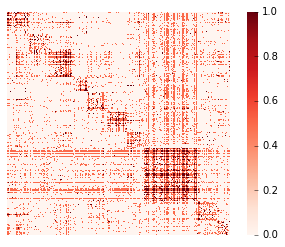

In [46]:
# plot affinity matrix

from sklearn.cluster import SpectralClustering
cluster = SpectralClustering(affinity='nearest_neighbors', n_clusters=10, n_neighbors=85, assign_labels='discretize')
cluster.fit(M_prop_pca.iloc[:,:70])
pat_affinity_matrix=pd.DataFrame(cluster.affinity_matrix_.todense(),index=M_prop_pca.index,columns=M_prop_pca.index)
pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)
labels=pat2surv.loc[:,'K10']
pat_affinity_matrix=pd.concat([pat_affinity_matrix,labels],join='inner',axis=1).sort_values('K10')
pat_affinity_matrix=pd.concat([pat_affinity_matrix.T,labels],join='inner',axis=1).sort_values('K10')
pat_affinity_matrix=pat_affinity_matrix.drop('K10',axis=1)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(pat_affinity_matrix,xticklabels=False, yticklabels=False,cmap='Reds',square=True)
plt.savefig('PatByPat_affinity_matrix.png', dpi=600)
plt.show()
pat_affinity_matrix[pat_affinity_matrix<0.5]=np.NAN

pat_affinity_matrix.stack().to_csv('affinity_matrix_stack.txt', sep='\t')

In [47]:
ttest_fdr_cut=0.3
fisher_p_cut=0.05

for subtype in range(10):
    print subtype
    essential_genes=set()
    gene2info={}
    for line in open('network/subtype_{}.noa'.format(subtype)).read().splitlines()[1:]:
        a=line.split('\t')
        ttest_fdr=float(a[3])
        fisher_p=float(a[4])
        if ttest_fdr<=ttest_fdr_cut:
            if fisher_p<=fisher_p_cut:
                essential_genes.add(a[0])
            gene2info[a[0]]=[ttest_fdr,fisher_p]
    header=True
    line_out=set()
    gene2line={}
    for line in open('network/subtype_{}.txt'.format(subtype)).read().splitlines():
        if header:
            line_header=line+'\n'
            header=False
            continue
        a=line.split('\t')
        if (a[0] in essential_genes) and (a[1] in essential_genes):
            line_out.add(line)
        elif a[0] in essential_genes:
            if a[1] not in gene2line:
                gene2line[a[1]]=set()
            gene2line[a[1]].add(line)
        elif a[1] in essential_genes:
            if a[0] not in gene2line:
                gene2line[a[0]]=set()
            gene2line[a[0]].add(line)
    for gene in gene2line:
        if len(gene2line[gene])>1:
            for line in gene2line[gene]:
                line_out.add(line)
    open('network/subtype_{}_dist1.txt'.format(subtype),'wb').write(line_header+'\n'.join(line_out)+'\n'+
                                                                    '\n'.join(essential_genes))

0
1
2
3
4
5
6
7
8
9


#### Fisher test subtype vs. disease

In [3]:
import scipy.stats as stats

In [4]:
df = pd.read_table('subtype2disease_wnames.txt', index_col=0)
df = df.fillna(0)

In [5]:
df_fisher = df.copy()

In [7]:
for index, row in df.iterrows():
    for column in df.columns:
        odds_ratio, p = stats.fisher_exact([[df.loc[index,column], 
                                             df.loc[index,df.columns!=column].sum()], 
                                            [df.loc[df.index!=index,column].sum(), 
                                             df.loc[df.index!=index,df.columns!=column].sum().sum()]], 
                                           alternative='greater')
        df_fisher.loc[index,column] = p

In [8]:
df_fisher.to_csv('subtype2disease_fisher_p.txt', sep='\t')

In [9]:
df_fisher_fdr = pd.read_table('subtype2disease_fisher_fdr.txt', index_col=0)

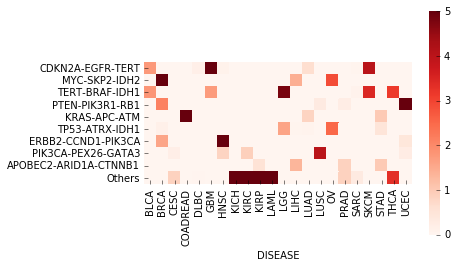

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap((-np.log10(df_fisher_fdr)).fillna(0).T.clip(lower=0,upper=5),cmap='Reds', square=True)
plt.savefig('subtype2disease_fisher_fdr.pdf')